In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from ml_utils.util import remove_empty_from_array
from ml_utils.util import flatten

In [2]:
path2target = '/Users/y1u0d2/desktop/Lab/result/n2p2/Si/sf/02'

In [3]:
if os.path.exists(os.path.join(path2target, 'function.data')):
    with open(os.path.join(path2target, 'function.data'), mode='r') as f:
        lines = [s.strip() for s in f.readlines()]

In [4]:
idx_list = []
for i, line in enumerate(lines):
    if len(remove_empty_from_array(line.split(' '))) == 1:
        idx_list.append(i)

In [5]:
sf_val_list = []
for i, idx in enumerate(idx_list):
    try:
        block = lines[idx+1:idx_list[i+1]-1]
    except:
        block = lines[idx+1:-1]
    
    for l in block:
        sf_val_list.append(list(map(float, remove_empty_from_array(l.split(' ')))))

In [6]:
# get column name

with open(os.path.join(path2target, 'input.nn'), mode='r') as f:
    lines = [s.strip() for s in f.readlines()]

sf_lines = list(filter(lambda x: 'symfunction_short' in x, lines))

In [7]:
sf_columns = []
for l in sf_lines:
    arr = l.split(' ')
    eta = arr[-3]
    rs = arr[-2]
    rcut = arr[-1]
    sf_columns.append(f'eta-{eta}_rs-{rs}_rcut-{rcut}')

In [8]:
df_sf= pd.DataFrame(data=np.array(sf_val_list)[:,1:], columns=sf_columns)

In [9]:
from analyze.n2p2_lattice import N2p2Lattice, get_structures_for_n2p2_lattice

structures = get_structures_for_n2p2_lattice(path2target, 'input.data')

In [10]:
force_df_list = []
mpid_list = []


for structure in structures:
    n2p2_lattice = N2p2Lattice(structure)

    # if 'mp-149' in n2p2_lattice.mpid:
    #     continue

    each_df = pd.DataFrame(data=n2p2_lattice.force, columns=['fx', 'fy', 'fz'])
    each_df['mpid'] = n2p2_lattice.mpid
    each_df['atom_energy'] = n2p2_lattice.energy / n2p2_lattice.n_atoms
    force_df_list.append(each_df.copy())

force_df = pd.concat(force_df_list)
force_df = force_df.reset_index(drop=True)

In [11]:
df_analyze = pd.concat([df_sf, force_df], axis=1)

## Machine learning

In [12]:
feature_cols =list(filter(lambda x: 'eta' in x, df_analyze.columns))
target = 'atom_energy'

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(data=scaler.fit_transform(df_analyze[feature_cols]), columns=feature_cols)

In [14]:
from sklearn.model_selection import train_test_split

# X_train,X_test,y_train,y_test = train_test_split(df_analyze[feature_cols], df_analyze[target], test_size=0.1,shuffle=True, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(df_scaled, df_analyze[target], test_size=0.1,shuffle=True, random_state=42)

In [15]:
import lightgbm as lgb
from lightgbm import *

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の評価関数
          'learning_rate': 0.01,         # 学習率
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=10000,
                  callbacks=[
                    early_stopping(stopping_rounds=100, verbose=True),
                    log_evaluation(),
                    record_evaluation(lgb_results)
                    ]
                  )  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31875
[LightGBM] [Info] Number of data points in the train set: 176247, number of used features: 125
[LightGBM] [Info] Start training from score -633.065236
[1]	Train's rmse: 1.88529	Test's rmse: 1.87057
Training until validation scores don't improve for 100 rounds
[2]	Train's rmse: 1.88169	Test's rmse: 1.86697
[3]	Train's rmse: 1.87821	Test's rmse: 1.86351
[4]	Train's rmse: 1.87476	Test's rmse: 1.86009
[5]	Train's rmse: 1.87134	Test's rmse: 1.85669
[6]	Train's rmse: 1.86802	Test's rmse: 1.85339
[7]	Train's rmse: 1.8647	Test's rmse: 1.85011
[8]	Train's rmse: 1.86146	Test's rmse: 1.84687
[9]	Train's rmse: 1.85831	Test's rmse: 1.84374
[10]	Train's rmse: 1.85517	Test's rmse: 1.84063
[11]	Train's rmse: 1.85214	Test's rmse: 1.83763
[12]	Train's rmse: 1.8491	Test's rmse: 1.83463
[13]	Train's rmse: 1.8

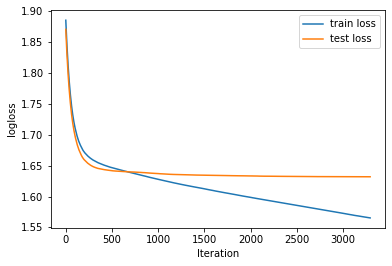

In [16]:
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
ax1 = fig.add_subplot(111)
  
ax1.set_xlabel('Iteration')
ax1.set_ylabel('logloss')
 
ax1.plot(loss_train, label='train loss')
ax1.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

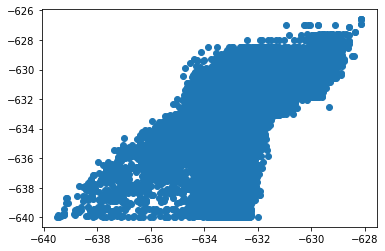

In [17]:
plt.scatter(model.predict(X_train), y_train)

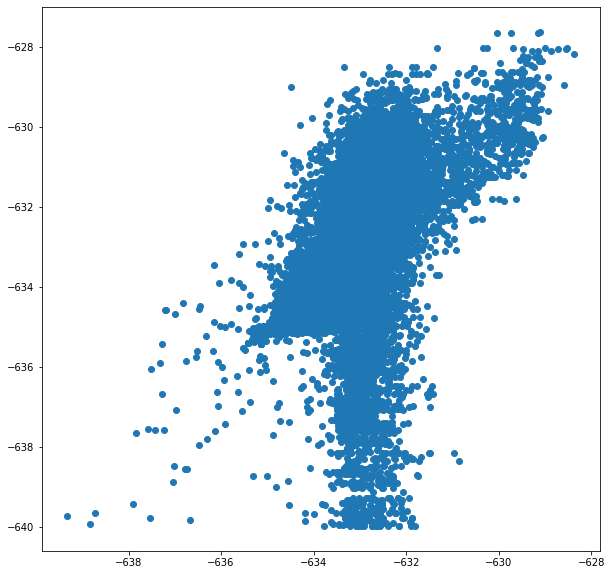

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.scatter(model.predict(X_test), y_test)

In [19]:
from sklearn.metrics import r2_score

r2_score(y_test, model.predict(X_test))

0.2416246104547699

In [20]:
import shap
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from scipy import stats
from lightgbm import *

In [21]:
param_dist = {
    'learning_rate': stats.uniform(0.09, 0.25),
    'num_leaves': stats.randint(20,40),
    'max_depth': [10, 12]
}

regr_lgbm = LGBMRegressor(n_estimators=150, random_state=0, n_jobs=-1)

In [22]:
model = BoostSearch(
    regr_lgbm, param_grid=param_dist,
    n_iter=8, sampling_seed=0
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0)


8 trials detected for ('learning_rate', 'num_leaves', 'max_depth')



'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


trial: 0001 ### iterations: 00052 ### eval_score: 2.68786
trial: 0002 ### iterations: 00086 ### eval_score: 2.67455
trial: 0003 ### iterations: 00101 ### eval_score: 2.6805
trial: 0004 ### iterations: 00070 ### eval_score: 2.68315
trial: 0005 ### iterations: 00070 ### eval_score: 2.67812
trial: 0006 ### iterations: 00023 ### eval_score: 2.69244
trial: 0007 ### iterations: 00082 ### eval_score: 2.68479
trial: 0008 ### iterations: 00032 ### eval_score: 2.6965


BoostSearch(estimator=LGBMRegressor(n_estimators=150, random_state=0), n_iter=8,
            param_grid={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16560f460>,
                        'max_depth': [10, 12],
                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16560f370>},
            sampling_seed=0)

In [23]:
model.estimator_, model.best_params_, model.best_score_

(LGBMRegressor(learning_rate=0.1350674222191923, max_depth=10, n_estimators=150,
               num_leaves=38, random_state=0),
 {'learning_rate': 0.1350674222191923, 'num_leaves': 38, 'max_depth': 10},
 2.6745465583247556)

In [24]:
(model.score(X_test, y_test))

0.23839906002883282

In [25]:
model = BoostRFE(
    regr_lgbm, min_features_to_select=5, step=1,
    importance_type='shap_importances', train_importance=False
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=6, verbose=0)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


BoostRFE(estimator=LGBMRegressor(n_estimators=150, random_state=0),
         importance_type='shap_importances', min_features_to_select=5,
         train_importance=False)

In [26]:
model.estimator_, model.n_features_

(LGBMRegressor(n_estimators=150, random_state=0), 45)

In [27]:
df_analyze[feature_cols].loc[:, model.support_].columns

Index(['eta-5.113_rs-1.0_rcut-3.0', 'eta-2.59_rs-1.5_rcut-3.0',
       'eta-10.12_rs-0.8278_rcut-3.0', 'eta-33.03_rs-0.5_rcut-3.0',
       'eta-18.18_rs-0.674_rcut-3.0', 'eta-5.505_rs-1.225_rcut-3.0',
       'eta-3.289_rs-1.721_rcut-3.0', 'eta-1.886_rs-2.272_rcut-3.0',
       'eta-2.876_rs-1.333_rcut-4.0', 'eta-2.914_rs-1.414_rcut-4.0',
       'eta-2.99_rs-1.523_rcut-4.0', 'eta-1.571_rs-2.101_rcut-4.0',
       'eta-0.8251_rs-2.899_rcut-4.0', 'eta-3.096_rs-1.633_rcut-4.0',
       'eta-17.1_rs-0.7546_rcut-4.0', 'eta-9.808_rs-0.9964_rcut-4.0',
       'eta-5.625_rs-1.316_rcut-4.0', 'eta-0.8849_rs-2.404_rcut-5.0',
       'eta-3.73_rs-1.25_rcut-5.0', 'eta-1.865_rs-1.768_rcut-5.0',
       'eta-1.914_rs-1.904_rcut-5.0', 'eta-10.95_rs-0.9432_rcut-5.0',
       'eta-2.065_rs-2.172_rcut-5.0', 'eta-1.278_rs-2.0_rcut-6.0',
       'eta-0.6145_rs-2.884_rcut-6.0', 'eta-0.2954_rs-4.16_rcut-6.0',
       'eta-2.59_rs-1.5_rcut-6.0', 'eta-1.295_rs-2.121_rcut-6.0',
       'eta-1.329_rs-2.284_rcut-6.0', 'eta-

In [30]:
for col in df_analyze[feature_cols].loc[:, model.support_].columns:
    eta = col.split('_')[0].split('-')[-1]
    rs = col.split('_')[1].split('-')[-1]
    rcut = col.split('_')[2].split('-')[-1]
    print(f'symfunction_short Si 2 Si {eta} {rs} {rcut}')

symfunction_short Si 2 Si 5.113 1.0 3.0
symfunction_short Si 2 Si 2.59 1.5 3.0
symfunction_short Si 2 Si 10.12 0.8278 3.0
symfunction_short Si 2 Si 33.03 0.5 3.0
symfunction_short Si 2 Si 18.18 0.674 3.0
symfunction_short Si 2 Si 5.505 1.225 3.0
symfunction_short Si 2 Si 3.289 1.721 3.0
symfunction_short Si 2 Si 1.886 2.272 3.0
symfunction_short Si 2 Si 2.876 1.333 4.0
symfunction_short Si 2 Si 2.914 1.414 4.0
symfunction_short Si 2 Si 2.99 1.523 4.0
symfunction_short Si 2 Si 1.571 2.101 4.0
symfunction_short Si 2 Si 0.8251 2.899 4.0
symfunction_short Si 2 Si 3.096 1.633 4.0
symfunction_short Si 2 Si 17.1 0.7546 4.0
symfunction_short Si 2 Si 9.808 0.9964 4.0
symfunction_short Si 2 Si 5.625 1.316 4.0
symfunction_short Si 2 Si 0.8849 2.404 5.0
symfunction_short Si 2 Si 3.73 1.25 5.0
symfunction_short Si 2 Si 1.865 1.768 5.0
symfunction_short Si 2 Si 1.914 1.904 5.0
symfunction_short Si 2 Si 10.95 0.9432 5.0
symfunction_short Si 2 Si 2.065 2.172 5.0
symfunction_short Si 2 Si 1.278 2.0 6.0

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(df_analyze[feature_cols])

array([[-0.04566402,  0.01909504,  0.1148133 , ..., -0.63391221,
        -0.61200485, -0.43142399],
       [-0.15170157, -0.3273443 , -0.55669818, ...,  1.02261992,
         2.1396695 ,  3.06959217],
       [-0.26771452, -0.45345816, -0.69559364, ...,  0.94026602,
         2.10110463,  3.20230088],
       ...,
       [ 1.84634874,  1.83289434,  1.78500171, ...,  1.77428784,
         1.05162841, -0.04965592],
       [ 0.70702365,  0.77595032,  0.86516767, ..., -0.16722865,
        -0.44075682, -0.42721304],
       [ 1.02880864,  1.13997399,  1.29570407, ..., -0.33398886,
        -0.52185778, -0.43029397]])